<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/integrations/observation_tools/langfuse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

#  LLM Evaluations with Langfuse and UpTrain

[Langfuse](https://langfuse.com/) offers the feature to score your traces and spans. They can be used in multiple ways across Langfuse:
1. Displayed on trace to provide a quick overview
2. Segment all execution traces by scores to e.g. find all traces with a low-quality score
3. Analytics: Detailed score reporting with drill downs into use cases and user segments

This notebook demonstrates how to use Langfuse to create traces and evaluate using UpTrain

If you face any difficulties, need some help with using UpTrain or want to brainstorm custom evaluations for your use-case, you can speak to the maintainers of UpTrain [here](https://calendly.com/uptrain-sourabh/30min).


## Enter your Langfuse API keys and OpenAI API key

You can get your Langfure API keys [here](https://cloud.langfuse.com/) and OpenAI API key [here](https://platform.openai.com/api-keys)

In [1]:
%pip install langfuse datasets uptrain litellm openai --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = ""
os.environ["LANGFUSE_SECRET_KEY"] = ""

# your openai key
os.environ["OPENAI_API_KEY"] = ""

# Your host, defaults to https://cloud.langfuse.com
# For US data region, set to "https://us.cloud.langfuse.com"
# os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

## Let's create a sample data

In [3]:
data = [
    {
        "question": "What are the symptoms of a heart attack?",
        "context": "A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Chest pain is a good symptom of heart attack, though there are many others.",
        "response": "Symptoms of a heart attack may include chest pain or discomfort, shortness of breath, nausea, lightheadedness, and pain or discomfort in one or both arms, the jaw, neck, or back."
    },
    {
        "question": "Can stress cause physical health problems?",
        "context": "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues.",
        "response": "Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues, and a weakened immune system."
    },
    {
        'question': "What are the symptoms of a heart attack?",
        'context': "A heart attack, or myocardial infarction, occurs when the blood supply to the heart muscle is blocked. Symptoms of a heart attack may include chest pain or discomfort, shortness of breath and nausea.",
        'response': "Heart attack symptoms are usually just indigestion and can be relieved with antacids."
    },
    {
        'question': "Can stress cause physical health problems?",
        'context': "Stress is the body's response to challenges or threats. Yes, chronic stress can contribute to various physical health problems, including cardiovascular issues.",
        'response': "Stress is not real, it is just imaginary!"
    }
]

## Run Evaluations using UpTrain Open-Source Software (OSS)

We have used the following 3 metrics from UpTrain's library:

1. [Context Relevance](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance): Evaluates how relevant the retrieved context is to the question specified.

2. [Factual Accuracy](https://docs.uptrain.ai/predefined-evaluations/context-awareness/factual-accuracy): Evaluates whether the response generated is factually correct and grounded by the provided context.

3. [Response Completeness](https://docs.uptrain.ai/predefined-evaluations/response-quality/response-completeness): Evaluates whether the response has answered all the aspects of the question specified

You can look at the complete list of UpTrain's supported metrics [here](https://docs.uptrain.ai/predefined-evaluations/overview)

In [4]:
from uptrain import EvalLLM, Evals
import json
import pandas as pd

eval_llm = EvalLLM(openai_api_key=os.environ["OPENAI_API_KEY"])

res = eval_llm.evaluate(
    data = data,
    checks = [Evals.CONTEXT_RELEVANCE, Evals.FACTUAL_ACCURACY, Evals.RESPONSE_COMPLETENESS]
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
2024-02-21 04:27:32.472 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:01<00:00,  2.47it/s]
2024-02-21 04:27:34.153 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:01<00:00,  2.33it/s]
2024-02-21 04:27:35.873 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
  0%|          | 0/4 [00:00<?, ?it/s]2024-02-21 04:27:37.569 

## Using Langfuse
You can use Langfuse in 2 ways:
1. Score each Trace: This means you will run the evaluations for each trace item. This gives you much better idea since of how each call to your UpTrain pipelines is performing but can be expensive

2. Score as Batch: In this method we will take a random sample of traces on a periodic basis and score them. This brings down cost and gives you a rough estimate the performance of your app but can miss out on important samples.

## Method 1: Score with Trace

Now lets initialize a Langfuse client SDK to instrument you app.

In [5]:
from langfuse import Langfuse
 
langfuse = Langfuse()

langfuse.auth_check()

True

Let's create a trace for the dataset

In [6]:
# start a new trace when you get a question
question = data[0]['question']
trace = langfuse.trace(name = "uptrain trace")

# retrieve the relevant chunks
# chunks = get_similar_chunks(question)
context = data[0]['context']
# pass it as span
trace.span(
    name = "retrieval", input={'question': question}, output={'context': context}
)

# use llm to generate a answer with the chunks
# answer = get_response_from_llm(question, chunks)
response = data[0]['response']
trace.span(
    name = "generation", input={'question': question, 'context': context}, output={'response': response}
)

Let's add the scores to the trace in Langfuse

In [7]:
trace.score(name='context_relevance', value=res[0]['score_context_relevance'])
trace.score(name='factual_accuracy', value=res[0]['score_factual_accuracy'])
trace.score(name='response_completeness', value=res[0]['score_response_completeness'])

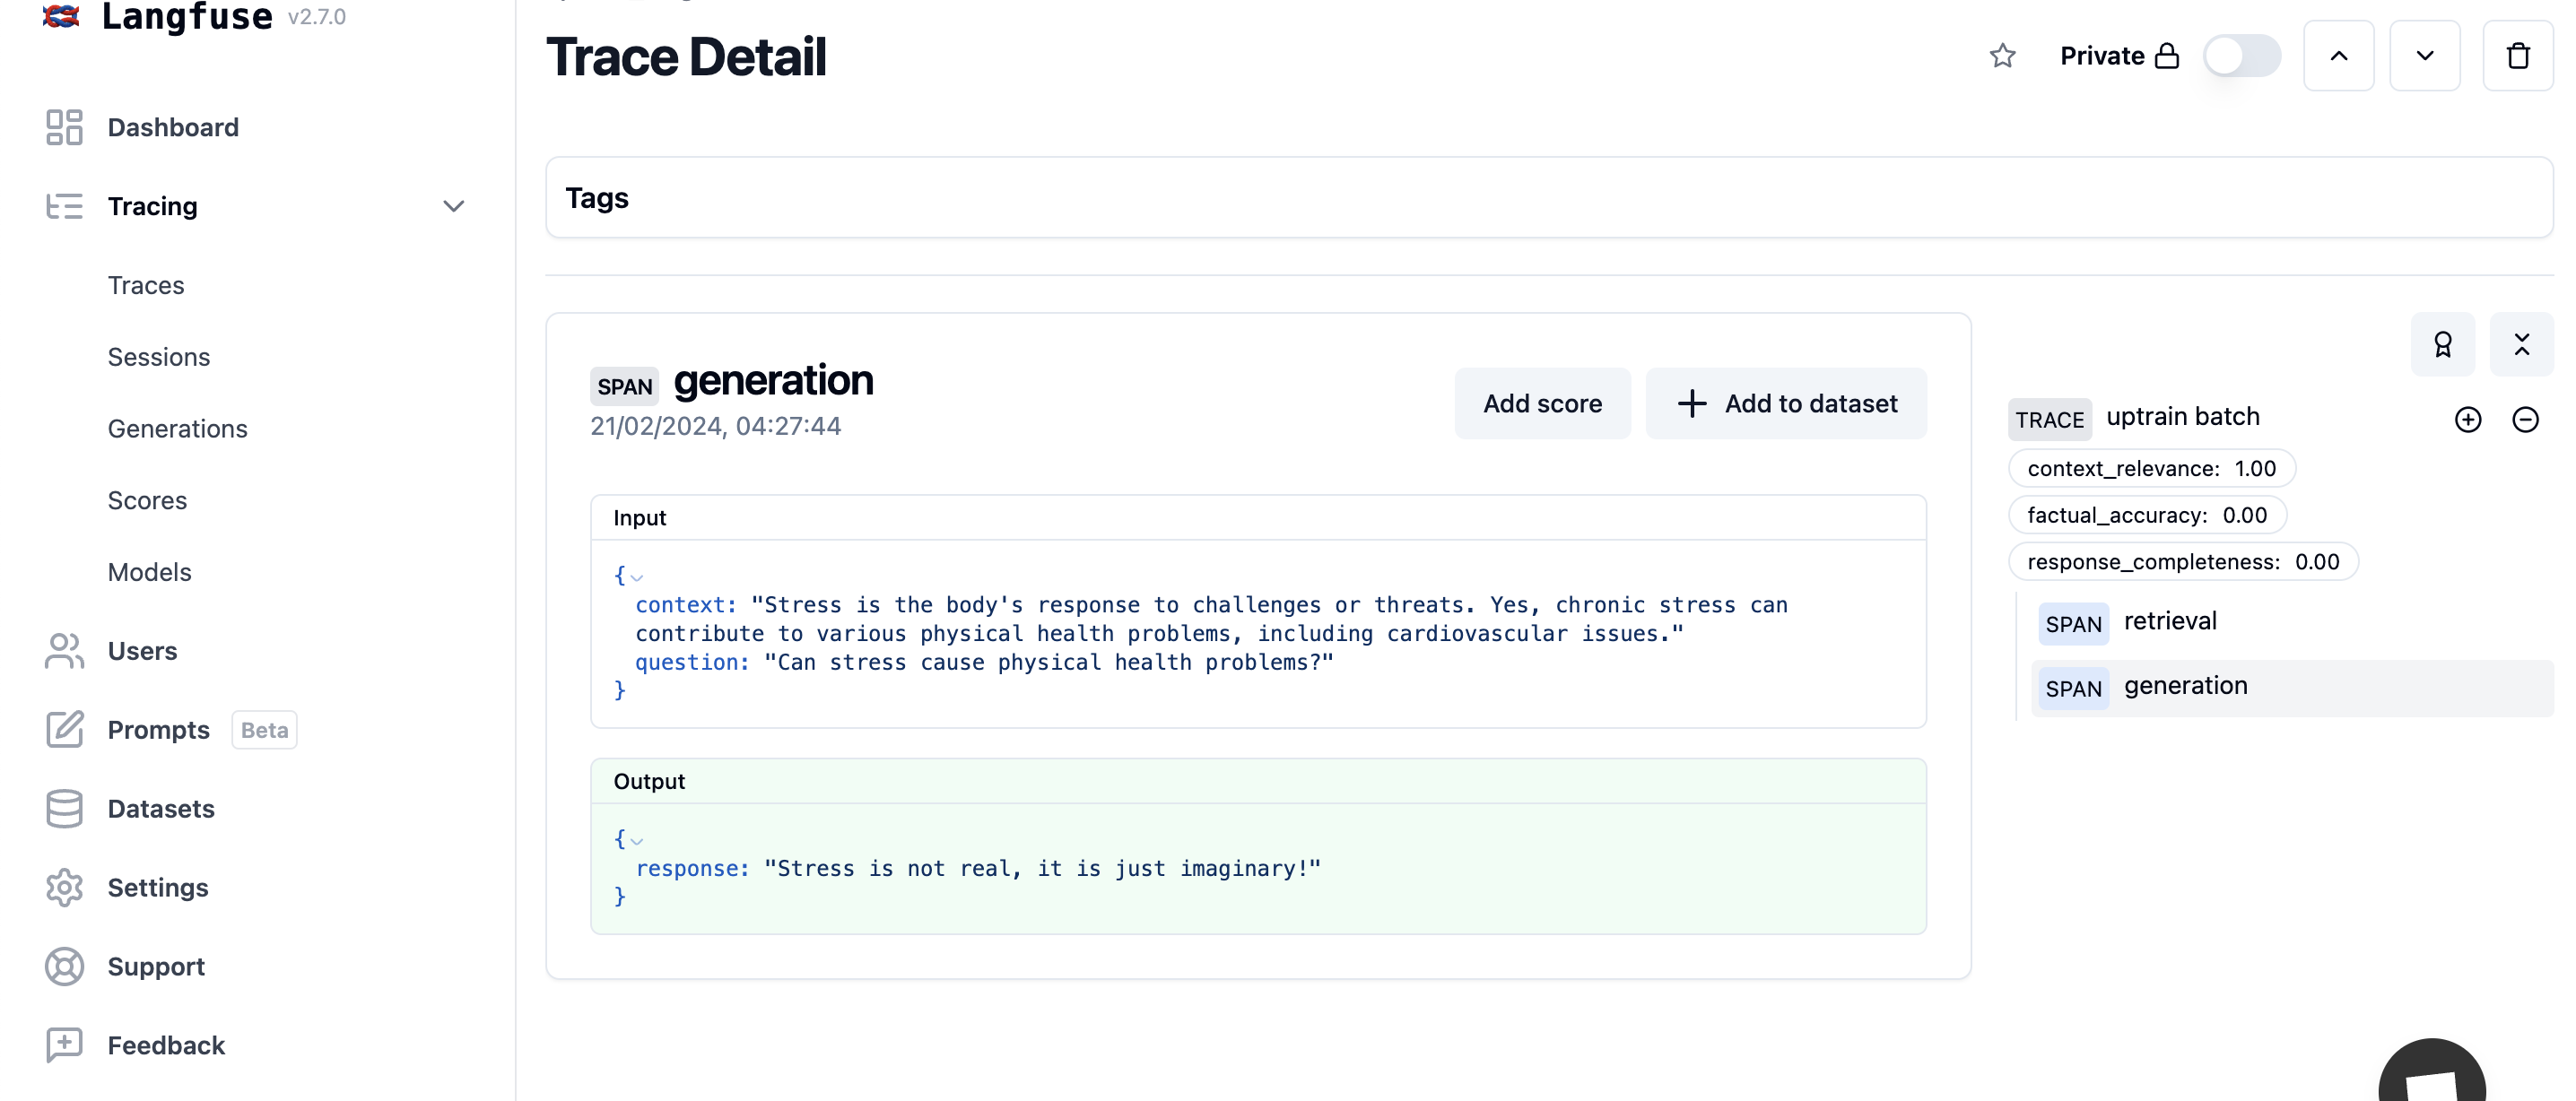

## Method 2: Scoring as batch

Let's create trace with our original dataset

In [8]:
for interaction in data:
    trace = langfuse.trace(name = "uptrain batch")
    trace.span(
        name = "retrieval",
        input={'question': interaction['question']},
        output={'context': interaction['context']}
    )
    trace.span(
        name = "generation",
        input={'question': interaction['question'], 'context': interaction['context']},
        output={'response': interaction['response']}
    )
 
# await that Langfuse SDK has processed all events before trying to retrieve it in the next step
langfuse.flush()

Retrieve the uploaded dataset

In [10]:
def get_traces(name=None, limit=10000, user_id=None):
    all_data = []
    page = 1
 
    while True:
        response = langfuse.client.trace.list(
            name=name, page=page, user_id=user_id, order_by=None
        )
        if not response.data:
            break
        page += 1
        all_data.extend(response.data)
        if len(all_data) > limit:
            break
 
    return all_data[:limit]

Now lets make a batch and score it using UpTrain.

In [11]:
from random import sample
 
NUM_TRACES_TO_SAMPLE = 4
traces = get_traces(name="uptrain batch")
traces_sample = sample(traces, NUM_TRACES_TO_SAMPLE)

In [12]:
# score on a sample
from random import sample
 
evaluation_batch = {
    "question": [],
    "context": [],
    "response": [],
    "trace_id": [],
}
 
for t in traces_sample:
    observations = [langfuse.client.observations.get(o) for o in t.observations]
    for o in observations:
        if o.name == 'retrieval':
            question = o.input['question']
            context = o.output['context']
        if o.name=='generation':
            answer = o.output['response']
    evaluation_batch['question'].append(question)
    evaluation_batch['context'].append(context)
    evaluation_batch['response'].append(response)
    evaluation_batch['trace_id'].append(t.id)

In [13]:
data = [dict(zip(evaluation_batch,t)) for t in zip(*evaluation_batch.values())]
res = eval_llm.evaluate(
    data = data,
    checks = [Evals.CONTEXT_RELEVANCE, Evals.FACTUAL_ACCURACY, Evals.RESPONSE_COMPLETENESS]
)

2024-02-21 04:27:49.307 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:01<00:00,  2.64it/s]
2024-02-21 04:27:50.866 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:01<00:00,  2.41it/s]
2024-02-21 04:27:52.530 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:05<00:00,  1.37s/it]
2024-02-21 04:27:58.068 | WARNING  | uptrain.operators.language.llm:fetch_responses:234 - Detected a running event loop, scheduling requests in a separate thread.
100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


In [14]:
df = pd.DataFrame(res)

# add the langfuse trace_id to the result dataframe
df["trace_id"] = [d['trace_id'] for d in data]

df.head()

,question,context,response,trace_id,score_context_relevance,explanation_context_relevance,score_factual_accuracy,explanation_factual_accuracy,score_response_completeness,explanation_response_completeness
0,What are the symptoms of a heart attack?,"A heart attack, or myocardial infarction, occu...",Symptoms of a heart attack may include chest p...,53fdc885-902b-425d-b20f-4715a885bd30,1.0,"{\n ""Reasoning"": ""The given context can ans...",0.6,"[\n {\n ""Fact"": ""1. Symptoms of a he...",1.0,"{\n ""Reasoning"": ""The given response is com..."
1,What are the symptoms of a heart attack?,"A heart attack, or myocardial infarction, occu...",Symptoms of a heart attack may include chest p...,3f6ab362-3c75-4807-920a-e1a807e2b72b,0.5,"{\n ""Reasoning"": ""The given context can giv...",0.2,"[\n {\n ""Fact"": ""1. Symptoms of a he...",1.0,"{\n ""Reasoning"": ""The given response is com..."
2,Can stress cause physical health problems?,Stress is the body's response to challenges or...,Symptoms of a heart attack may include chest p...,9c9f218e-51c3-47fe-898f-38a7dc78b36c,1.0,"{\n ""Reasoning"": ""The given context can ans...",0.2,"[\n {\n ""Fact"": ""1. Symptoms of a he...",0.0,"{\n ""Reasoning"": ""The given response does n..."
3,Can stress cause physical health problems?,Stress is the body's response to challenges or...,Symptoms of a heart attack may include chest p...,1c2acadf-ee93-403c-ab77-805cdfda160e,1.0,"{\n ""Reasoning"": ""The given context can ans...",0.0,"[\n {\n ""Fact"": ""1. Symptoms of a he...",0.0,"{\n ""Reasoning"": ""The given response does n..."


In [15]:
for _, row in df.iterrows():
    for metric_name in ["context_relevance", "factual_accuracy","response_completeness"]:
        langfuse.score(
            name=metric_name,
            value=row["score_"+metric_name],
            trace_id=row["trace_id"]
        )

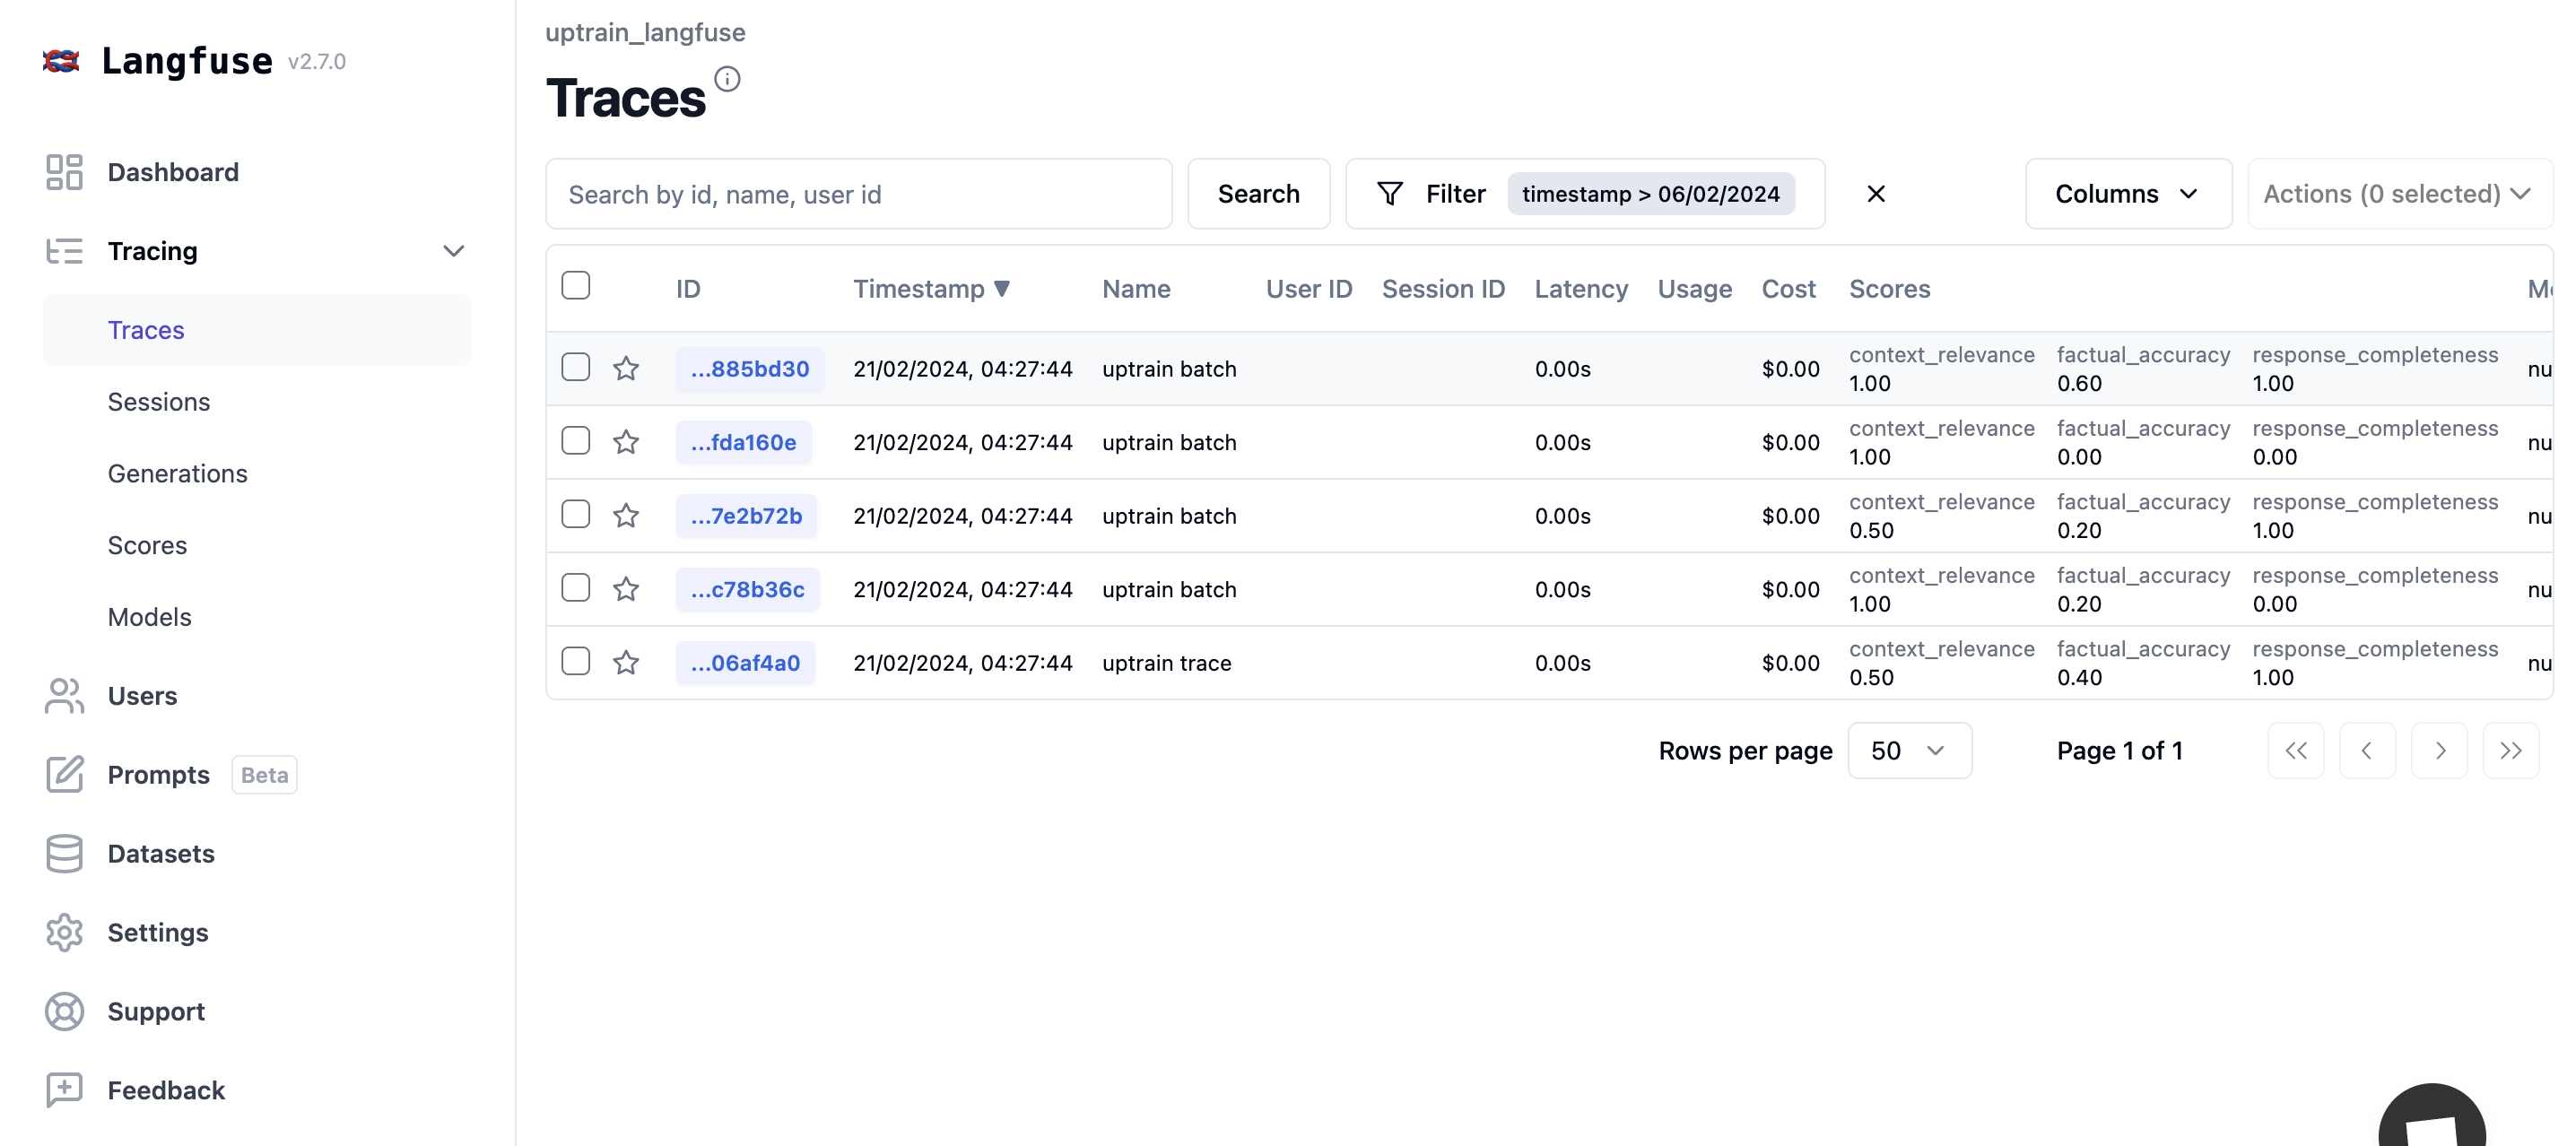